In [20]:
import random, os, re, multiprocessing, nltk, gc
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification , get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import ast

In [2]:
df = pd.read_csv('Roberta_tkn.csv')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)

In [5]:
input_ids = torch.tensor(df['input_ids'].tolist())
attention_masks = torch.tensor(df['attention_mask'].tolist())
labels = torch.tensor(df['label'].tolist())

In [6]:
torch.save((input_ids, attention_masks, labels), 'tokenized_Roberta_data.pt')

In [7]:
X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train, y_val = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

In [8]:
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val)

In [9]:
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size, pin_memory=True)
val_loader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size, pin_memory=True)

In [10]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [16]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 1
)

In [17]:
# Training function (runs one chunk at a time)
def train_in_chunks(model, train_loader, val_loader, chunk_size=100_000, epochs=1):
    history = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        total_loss, y_preds, y_true = 0, [], []

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels_cpu = b_labels.cpu().numpy()
            y_preds.extend(preds)
            y_true.extend(labels_cpu)
            total_loss += loss.item()

        train_acc = accuracy_score(y_true, y_preds)
        val_loss, val_acc = evaluate(model, val_loader)
        history.append({'train_loss': total_loss / len(train_loader), 'train_acc': train_acc,
                        'val_loss': val_loss, 'val_acc': val_acc})
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

In [18]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss, y_preds, y_true = 0, [], []

    for batch in tqdm(dataloader, desc="Evaluating"):
        b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.cpu().numpy()
        total_loss += loss.item()
        y_preds.extend(preds)
        y_true.extend(labels)

    acc = accuracy_score(y_true, y_preds)
    return total_loss / len(dataloader), acc

In [21]:
# Train the model
history = train_in_chunks(model, train_loader, val_loader, epochs=1)


Epoch 1/1


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 6250/6250 [28:37<00:00,  3.64it/s]


Train Acc: 0.9844 | Val Acc: 0.9803


In [22]:
# Save model
torch.save(model.state_dict(), 'roberta_finetuned_downsampled.pt')

In [23]:
# Evaluate and print final report
model.eval()
all_preds, all_labels = [], []
for batch in val_loader:
    b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_mask)
    preds = torch.argmax(outputs.logits, dim=1).detach().cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(b_labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     50100
           1       0.97      0.99      0.98     49900

    accuracy                           0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000



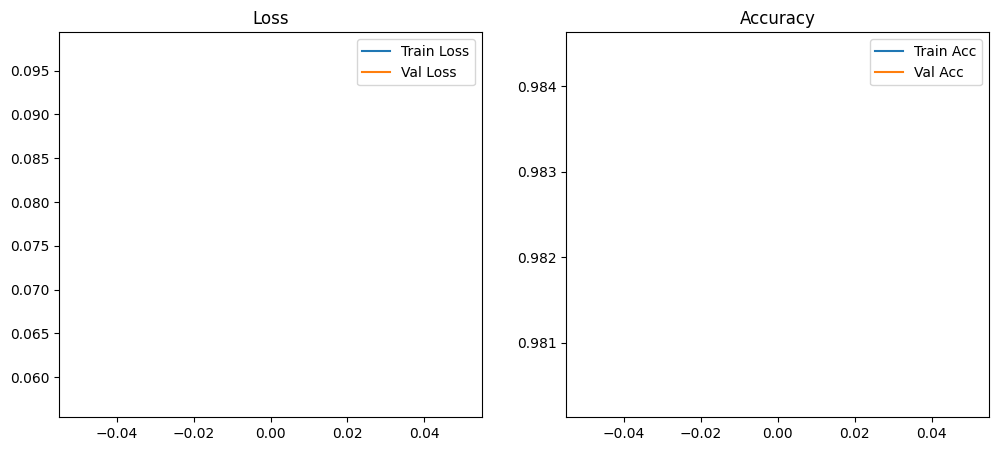

In [24]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x['train_loss'] for x in history], label='Train Loss')
plt.plot([x['val_loss'] for x in history], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.savefig("LOSS_Roberta.png")

plt.subplot(1, 2, 2)
plt.plot([x['train_acc'] for x in history], label='Train Acc')
plt.plot([x['val_acc'] for x in history], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.savefig("ACCURACY_Roberta.png")

plt.show()
